# Importing required libraries

In [ ]:
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import  optimizers
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Concatenate, AvgPool2D
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Input


In [ ]:
# To import necessary libraries from local text file
# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#   name=fn, length=len(uploaded[fn])))
# !pip install -r requiredLibraries.txt

#Access data via github
#!git clone https://github.com/AashishBhetuwal/Multi-Label-Image-Classification-on-Facial-Attributes-using-CNNs.git

In [ ]:
#Access data via github
!git clone https://github.com/AashishBhetuwal/Multi-Label-Image-Classification-on-Facial-Attributes-using-CNNs.git

Cloning into 'Multi-Label-Image-Classification-on-Facial-Attributes-using-CNNs'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 1529 (delta 2), reused 22 (delta 2), pack-reused 1507
Receiving objects: 100% (1529/1529), 294.23 MiB | 36.62 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (1509/1509), done.


# Data PreProcessing

In [ ]:
data=pd.read_csv('/content/Multi-Label-Image-Classification-on-Facial-Attributes-using-CNNs/labels.csv')
data.shape
data.head()

id  wrinkles  ...  hair_top  no_face_or_no_human
0  emotionet_3_10556.jpg         0  ...         2                    0
1  emotionet_3_10580.jpg         0  ...         2                    0
2  emotionet_3_10593.JPG         0  ...         3                    0
3  emotionet_3_10648.jpg         0  ...         3                    0
4  emotionet_3_1069.jpeg         0  ...         2                    0

[5 rows x 7 columns]

In [ ]:
size=96
X_dataset=[]
for i in tqdm(range(data.shape[0])):
  image_directory ='/content/Multi-Label-Image-Classification-on-Facial-Attributes-using-CNNs/001147628/' + data['id'][i]
  img=image.load_img(image_directory, target_size=(size,size,3))
  img = image.img_to_array(img)
  img=img/255.0
  X_dataset.append(img)
X=np.array(X_dataset)

 23%|██▎       | 338/1500 [00:03<00:20, 56.96it/s]/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
100%|██████████| 1500/1500 [00:17<00:00, 83.99it/s]


emotionet_3_998.jpg


(1500, 96, 96, 3)

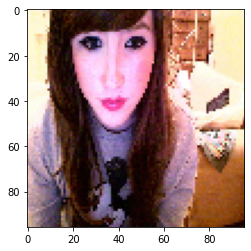

In [ ]:
#Validating if image array matches the labels
print(data['id'][1499])
plt.imshow(X[1499])
X.shape

In [ ]:
y=np.array(data.drop(['id','no_face_or_no_human'], axis=1))
y.shape

(1500, 5)

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X,y, random_state=20, test_size=0.40)
print('Training dataset shape: {}'.format(X_train.shape))
print('Training dataset shape: {}'.format(y_train.shape))
print('Testing dataset shape: {}'.format(X_test.shape))
print('Testing dataset shape: {}'.format(y_test.shape))

Training dataset shape: (900, 96, 96, 3)
Training dataset shape: (900, 5)
Testing dataset shape: (600, 96, 96, 3)
Testing dataset shape: (600, 5)


[1 0 0 1 2]


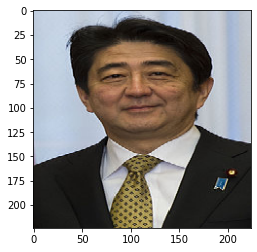

In [ ]:
print(y_train[3])
plt.imshow(X_train[3])

# Training

## Building CNN Model

In [ ]:
model = models.Sequential()
#first CNN layer
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", input_shape=(X_train[0].shape)))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
#second CNN layer
model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
#third CNN layer
model.add(Conv2D(filters=512, kernel_size=(3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
#fourth CNN layer
model.add(Conv2D(filters=512, kernel_size=(3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
#flatening the images before dense layers
model.add(Flatten())
#fully connected first layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
#fully connected second layer
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
#fully connected final layer
model.add(Dense(6, activation='softmax'))
model.summary()
plot_model(model)

#creating a checkpoint
checkpoint = ModelCheckpoint("/content/CNN_Sequential.h5", monitor='accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=4,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

#compiling the model
model.compile(optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
#training the model
print('Training the model now')
history = model.fit(X_train, y_train, 
                                epochs=10,
                                validation_data = (X_test, y_test),
                                callbacks=callbacks_list
                                )




---



##Using pre-trained VGG19 network to build Model
---



In [ ]:
# loading model without classifier layers
model = keras.applications.vgg19(include_top=False, weights="imagenet", input_shape=(X_train[0].shape)) 
# Adding new classifier layers
flat1 = layers.Flatten()(model.layers[-1].output)
fc1 = layers.Dense(4096, activation='relu')(flat1)
fc2 = layers.Dense(4096, activation='relu')(fc1)
output = layers.Dense(5, activation='softmax')(fc2)
# Define new model
model = Model(inputs=model.inputs, outputs=output)
model.summary()
plot_model(model)

#creating a checkpoint
checkpoint = ModelCheckpoint("/content/VGG19.h5", monitor='accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=4,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

#compiling the model
model.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
#training the model
print('Training the model now')
history = model.fit(X_train, y_train, 
                                epochs=10,
                                validation_data = (X_test, y_test),
                                callbacks=callbacks_list
                                )



---



##Using pre-trained EfficientNetB0 network to build Model

In [ ]:
# loading model without classifier layers
model = keras.applications.EfficientNetB0(include_top=True, weights="imagenet", input_shape=(X_train[0].shape)) 
# Adding new classifier layers
flat1 = layers.Flatten()(model.layers[-1].output)
fc1 = layers.Dense(512, activation='relu')(flat1)
fc2 = layers.Dense(512, activation='relu')(fc1)
output = layers.Dense(5, activation='softmax')(fc2)
# Define new model
model = Model(inputs=model.inputs, outputs=output)
model.summary()
plot_model(model)

#creating a checkpoint
checkpoint = ModelCheckpoint("/content/EfficientNetB0.h5", monitor='accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=4,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

#compiling the model
model.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
#training the model
print('Training the NASNetLarge model now')
history = model.fit(X_train, y_train, 
                                epochs=10,
                                validation_data = (X_test, y_test),
                                callbacks=callbacks_list)



---



##Using GoogLeNet network to build model

In [ ]:
def inception_block(x, filters):
    t1 = Conv2D(filters=filters[0], kernel_size=1, activation='relu')(x)

    t2 = Conv2D(filters=filters[1], kernel_size=1, activation='relu')(x)
    t2 = Conv2D(filters=filters[2], kernel_size=3, padding='same', activation='relu')(t2)

    t3 = MaxPool2D(pool_size=3, strides=1, padding='same')(x)
    t3 = Conv2D(filters=filters[5], kernel_size=1, activation='relu')(t3)

    output = Concatenate()([t1, t2, t3])
    return output

input = Input(shape=(X_train[0].shape))
x = Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation='relu')(input)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = Conv2D(filters=64, kernel_size=1, activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=3, strides=2)(x)

x = inception_block(x, filters=[256, 160, 320, 32, 128, 128])
x = AvgPool2D(pool_size=7, strides=1)(x)
x = Dropout(rate=0.4)(x)

x = Flatten()(x)
output = Dense(units=5, activation='softmax')(x)

model = Model(inputs=input, outputs=output)
model.summary()
plot_model(model)

#creating a checkpoint
checkpoint = ModelCheckpoint("/content/Inceptionv3.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=4,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

#compiling the model
print('Training the model now')
optimizer = ['Adam', 'SGD']
epochs=[10,10]
for i in range(len(optimizer)):
    print('Using optimizer: ' + optimizer[i] + ', Epoch: ' + str(epochs[i]))
    model.compile(loss='categorical_crossentropy',optimizer=optimizer[i], metrics=['accuracy'])
    #training the model
    history = model.fit(X_train, y_train, epochs=epochs[i] , validation_data=(X_test, y_test), callbacks=callbacks_list, shuffle=True)

##Using pre-trained ResNet50 with augmentated data to build Model 

In [ ]:
data_augmentation = Sequential(
    [  
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomZoom(0.1)
    ]
)
# The augmentation is being made part of the model. Note that data augmentation is inactive at test time.
# Creating a model that includes the augmentation stage
input_shape = (X_train[0].shape)
inputs = keras.Input(shape=input_shape)
# Augmenting images
x = data_augmentation(inputs)
# Adding the rest of the model
model = keras.applications.ResNet50V2(include_top=False,
    weights='imagenet', input_shape=input_shape)(x)
# Add new classifier layers
flat1 = layers.Flatten()(model)
outputs = layers.Dense(5, activation='softmax')(flat1)
# Define new model
model = Model(inputs=inputs, outputs= outputs)
model.summary()
plot_model(model)

#creating a checkpoint
checkpoint = ModelCheckpoint("/content/drive/MyDrive/COMP1804 Applied Machine Learning/Coursework/Model Weights/ResNet50V2.h5", 
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True
                          )
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

#compiling the model
print('Training the model now')
optimizer = ['Adam']
for i in range(len(optimizer)):
    print('Using optimizer: ' + optimizer[i] + ', Epoch: ' + str(epochs[i]))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer[i], metrics=['accuracy'])
#training the model
history = model.fit(X_train, y_train, epochs=10 , validation_data=(X_test, y_test), callbacks=callbacks_list, shuffle=True)

# Loss and Accuracy Evaluation

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show



In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(loss) + 1)
plt.plot(epochs, acc, 'y', label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.title('training and validation acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.legend(loc='lower right')
plt.show

#Testing

In [ ]:
from keras.models import load_model
#Specifying the saved model
filepath = "/content/drive/MyDrive/COMP1804 Applied Machine Learning/Coursework/Model Weights/ResNet50V2Freakles.h5"
# load the model
model = load_model(filepath)
_,acc=model.evaluate(X_test,y_test)
print('Accuracy=' , (acc*100.0), '%')
size=96
image_directory ='/content/Multi-Label-Image-Classification-on-Facial-Attributes-using-CNNs/Test Dataset/emotionet_3_202336.jpg'
img=image.load_img(image_directory, target_size=(size,size,3))
img = image.img_to_array(img)
img=img/255.0
img=np.expand_dims(img, axis=0)
test_labels=np.array(data.columns[1:6])
print(test_labels)
y_pred=model.predict(img)
y_pred
